# Chop network with BDM
Takes the data structures of a network and calculates BDM of the PPI matrix. Discards a given fraction of the edges and updates the DS file with the new ppi matrix.

In [1]:
import numpy as np
import scipy.sparse as sp
import pickle
from pybdm import BDM
from pybdm.utils import decompose_dataset
from pybdm.partitions import PartitionIgnore
from pybdm.partitions import PartitionRecursive
from algorithms import PerturbationExperiment, NodePerturbationExperiment

In [2]:
in_file = 'data_structures/DS/DS_toy_DSE_600_genes_500_drugs_400_se_4'
words = in_file.split('_')
sim_type = words[2]
# Fraction of edges to be discarded
cut_frac = 0.25

In [3]:
#Define function for sparse matrices of DECAGON
# Call it from another file better??
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [4]:
# Import original PPI matrix
with open(in_file,'rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

gene2idx Imported successfully
drug2idx Imported successfully
se_mono_name2idx Imported successfully
se_combo_name2idx Imported successfully
ddi_adj_list Imported successfully
ddi_degrees_list Imported successfully
dti_adj Imported successfully
ppi_adj Imported successfully
ppi_degrees Imported successfully
drug_feat Imported successfully
prot_feat Imported successfully


In [5]:
n_genes = len(gene2idx)
n_drugs = len(drug2idx)
n_se_combo = len(se_combo_name2idx)
n_se_mono = len(se_mono_name2idx)
print(n_genes,n_drugs,n_se_combo,n_se_mono)

500 400 4 600


In [91]:
# test random adj matrix
s = 100
b = np.random.randint(0,2,size=[s,s])
sym = np.floor((b+b.T)/2).astype(int)
sym[:,3] = np.zeros(s)
sym[3,:] = np.zeros(s)
ppi_adj = sp.csc_matrix(sym)
print(np.count_nonzero(sym))

2573


In [92]:
# Calculate algorithmic complexity
bdm = BDM(ndim=2, partition=PartitionRecursive)
ppi_per = PerturbationExperiment(bdm,metric='bdm',bipartite_network=False)
ppi_per.set_data(np.array(ppi_adj.todense()))
edge_complexity = ppi_per.run()
# Reshape to the adj matrix shape
complexity_mat = edge_complexity.reshape(np.shape(ppi_adj))

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


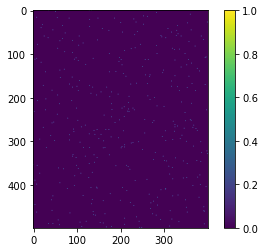

In [142]:
imshow(dti_mat)
colorbar()

In [95]:
# OPTION 1: USE ELEMENTWISE MULT TO FORM DENSE MATRIX 
eps = 0.0001 # The addition of this value makes the number of nonzero to coincide
true_cmplx = np.multiply(ppi_adj.todense(),complexity_mat+eps)
abs_cmplx = np.abs(true_cmplx[true_cmplx != 0])
cmplx = np.squeeze(np.asarray(abs_cmplx))
sorted_cmplx = np.sort(cmplx)[::-1]
l = len(sorted_cmplx)
print(np.count_nonzero(true_cmplx))
threshold = sorted_cmplx[np.floor(l*(1-cut_frac)).astype(int)]
# Dense matrix
new_ppi_adj = (np.abs(true_cmplx)>threshold).astype(int)
print(np.array_equal(new_ppi_adj,new_ppi_adj.T))
print(np.count_nonzero(new_ppi_adj))

2573
True
1929


In [81]:
# OPTION 2: USE INDICES TO FORM SPARSE MATRIX (FAILS!, THE MATRIX IS NOT NECESSARLY SYMMETRIC)
# Get coordinates and complexities of positive edges
coords,_,_ = sparse_to_tuple(ppi_adj)
l= np.shape(coords)[0]
true_cmplx = np.abs(complexity_mat[coords[:,0],coords[:,1]].reshape(l,1))
# Use dummy column to keep track of indices
a = np.concatenate((np.abs(true_cmplx),np.arange(l).reshape(l,1)),axis=1)
sorted_values = a[a[:,0].argsort()[::-1]]
# Discard the lowest complexity edges
remain = np.arange(np.floor(l*(1-cut_frac)),dtype=int)
new_values = sorted_values[remain,:]
indices = new_values[:,1].astype(int)
new_coords = coords[indices,:]
new_l = np.shape(new_coords)[0]
# New adjacency matrix (sparse)
new_ppi_adj = sp.csr_matrix((np.ones(new_l), (new_coords[:,0], new_coords[:,1])),\
                            shape=np.shape(ppi_adj))
print(np.array_equal(new_ppi_adj.todense(),new_ppi_adj.todense().T))
print(np.count_nonzero(new_ppi_adj.todense()))

False
1749


### Check for zero rows/columns

In [144]:
ppi_mat = new_ppi_adj
ppi_zero = np.where(~ppi_mat.any(axis=1))[0]
if len(ppi_zero)>0:
    ppi_mat = np.delete(np.delete(ppi_mat,ppi_zero,axis=1),ppi_zero,axis=0)
    print(np.shape(ppi_mat))
    dti_mat = dti_adj.todense()
    dti_rmd_genes = np.squeeze(np.array(dti_mat[ppi_zero,:]))
    print(rmd_genes.shape)
    dti_mat = np.delete(dti_mat,ppi_zero,axis=0)
    print(np.shape(dti_mat))
    dti_zero_drugs = np.where(~dti_mat.any(axis=1))[0]
    print(dti_zero_drugs)
    drugs2remove = np.nonzero(dti_rmd_genes)[0]
    drugs2remove = np.array([3,7]) #delete this
    if len(drugs2remove)>0:
        ddi_degrees_list = []
        for i in ddi_adj_list:
            ddi_mat = np.delete(np.delete(i.todense(),drugs2remove,axis=0),\
                                        drugs2remove,axis=1)
            print(np.shape(ddi_mat))
            ddi_degrees_list.append(np.array(ddi_mat.sum(axis=0)).squeeze())

(99, 99)
(400,)
(499, 400)
[  2   4   6   7   8  10  11  12  15  19  22  23  24  25  26  30  31  34
  36  38  39  41  43  44  47  48  51  53  55  57  60  62  64  66  71  73
  74  76  77  79  83  84  85  91  93  94  96  98 100 101 102 103 104 105
 106 111 116 118 120 122 123 126 127 128 131 132 134 136 138 142 144 146
 147 149 155 156 157 158 159 160 163 164 165 166 171 173 178 179 180 181
 182 185 186 188 189 191 193 195 199 201 202 205 206 208 209 212 215 216
 217 218 222 223 225 229 230 233 235 236 237 239 241 242 245 246 248 249
 255 259 260 261 264 266 269 274 279 280 282 288 291 293 305 306 307 309
 310 316 317 318 320 321 323 324 325 327 329 332 333 335 336 339 340 341
 343 347 349 350 352 354 359 365 366 367 368 369 370 372 374 376 378 380
 381 385 388 391 392 393 394 396 397 400 402 403 410 412 414 415 416 417
 418 419 422 426 427 429 430 431 432 438 439 442 444 448 449 452 453 455
 456 457 463 465 467 470 471 472 474 475 477 481 482 492 493 498]
(398, 398)
(398, 398)
(398, 398

In [44]:
np.shape(dti_adj.todense())

(500, 400)

In [147]:
ppi_zero

array([3])

In [148]:
dti_adj.todense()[:,2]

matrix([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

(99, 99)
(1, 400)
1


In [122]:
print(rmd_genes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
chop

In [ ]:
np.where(~ppi_degrees.any(axis=0))[0]

In [ ]:
data = {}
# Dictionaries
data['gene2idx'] = gene2idx
data['drug2idx'] = drug2idx
data['se_mono_name2idx'] = se_mono_name2idx
data['se_combo_name2idx'] = se_combo_name2idx
# DDI
data['ddi_adj_list'] = ddi_adj_list
data['ddi_degrees_list'] = ddi_degrees_list
# DTI
data['dti_adj'] = dti_adj
# PPI
data['ppi_adj'] = new_ppi_adj
data['ppi_degrees'] = ppi_degrees
# DSE
data['drug_feat'] = drug_feat

In [ ]:
# SAVING
out_file = 'data_structures/CHOP/ADJPPI_' + sim_type + '_DSE_' + str(n_se_mono) +\
            '_genes_' +str(n_genes) + '_drugs_' + str(n_drugs) + '_se_' + str(n_se_combo) +\
            '_cutfrac_'+str(cut_frac)
print(out_file)

In [ ]:
with open(out_file,'wb') as f:
    pickle.dump(new_ppi_adj, f)